# Clustering Pitcher Types to Better Predict Batter Outcomes

### Notebook Structure
1. Web Scrape BrooksBaseball<br>
    1.1 Extract URLs for all games<br>
    1.2 For each URL, scrape pitching stats<br>
2. Data Manipulation<br>
    2.1 Pull in pitcher dexterity from pitchFX<br>
    2.2 Take a weighted average of pitch types for each pitcher<br>
    2.3 Calculate the percentage pitch types for each pitcher<br>
    2.4 Calculate a velocity index for each pitcher<br>
    2.5 Data filtering<br>
    2.6 Normalize the dataset<br>
3. Dimensionality Reduction Analysis<br>
    3.1 Multicollinearity<br>
    3.2 Minimum Variance Threshold<br>
    3.3 PCA<br>
4. Cluster Analysis<br>
    4.1 Finding k through the Elbow Method<br>
    4.2 Analyzing Centers<br>
    


## Web Scraping BrooksBaseball

Let's import the required modudules and custom python scripts

In [1]:
import pandas
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
from multiprocessing import Pool
import sqlite3
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Next, I want to scrape pitching data from BrooksBaseball.com, and store it in a sqlite database. I achieved this in several steps. First, I generated all of the URLs that contained data that I eventually wanted to parse. I stored these urls in a table called urls.

In [2]:
conn = sqlite3.connect("data/database.db")
df = pandas.read_sql_query("select pitcher_id, pitcher_name, game_id, url from urls limit 5;", conn)
df

,pitcher_id,pitcher_name,game_id,url
0,407890,Colby Lewis,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...
1,451075,David Martinez,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...
2,451596,Yovani Gallardo,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...
3,464416,Yohan Pino,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...
4,488786,Louis Coleman,gid_2015_03_04_kcamlb_texmlb_1/,http://www.brooksbaseball.net/pfxVB/pfx.php?mo...


Next, for each of these URLs, I scraped the pitcher data for both the RHP and LHP versions of the webpage. I stored this data in a table called full_pitches.

In [3]:
df = pandas.read_sql_query("select pitcher_id, game_id, type_of_batters, pitch_type_code, pitch_type_desc, velo, count from full_pitches where type_of_data='pitch_info' limit 10;", conn)
df

,pitcher_id,game_id,type_of_batters,pitch_type_code,pitch_type_desc,velo,count
0,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,FA,Fastball,89.0,17.0
1,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,SI,Sinker,88.8,3.0
2,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,CH,Changeup,83.5,2.0
3,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,CU,Curveball,75.6,14.0
4,425794,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,FC,Cutter,86.1,17.0
5,425794,gid_2015_04_05_slnmlb_chnmlb_1/,RHB,FA,Fastball,89.3,18.0
6,425794,gid_2015_04_05_slnmlb_chnmlb_1/,RHB,SI,Sinker,90.5,1.0
7,425794,gid_2015_04_05_slnmlb_chnmlb_1/,RHB,CU,Curveball,76.2,12.0
8,425794,gid_2015_04_05_slnmlb_chnmlb_1/,RHB,FC,Cutter,85.5,17.0
9,435400,gid_2015_04_05_slnmlb_chnmlb_1/,LHB,FA,Fastball,95.2,7.0


## Data Manipulation

In the dataframe above, I've collected a row for every pitch type, for every pitcher in each of his appearances. I need to determine the percentage that each pitcher throws each kind of pitch, as well as the weighted average velocity. After a few SQL queries, I generate a table called weighted_totals. In addition, I remove all pitchers who have fewer than 200 total pitches in the dataset. I also add a p_throws column, which I pull in from the pitchFx database (linking using pitcher_id).

In [4]:
df = pandas.read_sql_query("select pitcher_id, type_of_batters, p_throws, pitch_type_code, velo, pitch_type_total, total_count from weighted_totals limit 10;", conn)
df

,pitcher_id,type_of_batters,p_throws,pitch_type_code,velo,pitch_type_total,total_count
0,112526,LHB,R,CH,81.478669,511.0,4868.0
1,112526,LHB,R,FA,90.337331,1409.0,4868.0
2,112526,LHB,R,FC,86.343846,130.0,4868.0
3,112526,LHB,R,FF,90.165217,46.0,4868.0
4,112526,LHB,R,FT,87.449351,77.0,4868.0
5,112526,LHB,R,SI,87.544860,2539.0,4868.0
6,112526,LHB,R,SL,81.412821,156.0,4868.0
7,112526,RHB,R,CH,81.554065,246.0,4954.0
8,112526,RHB,R,CU,85.200000,1.0,4954.0
9,112526,RHB,R,FA,90.454401,818.0,4954.0


From here, I can determine the percentage of pitch types that each pitcher throws by dividing the pitch_type_total by the total_count. Several pitch types are thrown so infrequently that it makes sense to group these into an "other" category.

In [5]:
df = pandas.read_sql_query("select pitch_type_code, pitch_type_desc, count(*) as count from full_pitches group by pitch_type_code, pitch_type_desc order by count desc", conn)
df

,pitch_type_code,pitch_type_desc,count
0,FA,Fastball,121845
1,SL,Slider,86604
2,SI,Sinker,68543
3,CU,Curveball,61785
4,CH,Changeup,59316
5,FC,Cutter,30019
6,FS,Splitter,10128
7,FF,Four-seam Fastball,9271
8,FT,Two-seam Fastball,3972
9,KC,Knuckle-Curve,842


There's a clear drop off after Two Seam Fastballs, so I will group KC, CS, KN, FO, and SB into an Other category.

To try to quantify how fast a pitcher throws, I created a field called velo_index. To get this value I use each pitcher's average fastball velocity (or the average velocity of that pitcher's fastest pitch type).

In [6]:
df = pandas.read_sql_query("select pitcher_id, p_throws, type_of_batters, velo_index, percent_ch, percent_fa, percent_fc, percent_ff, percent_fs, percent_ft, percent_si, percent_sl, percent_other from pitch_frequencies limit 10;", conn)
df

,pitcher_id,p_throws,type_of_batters,velo_index,percent_ch,percent_fa,percent_fc,percent_ff,percent_fs,percent_ft,percent_si,percent_sl,percent_other
0,112526,R,LHB,90.337331,0.104971,0.289441,0.026705,0.009449,0.000000,0.015818,0.521569,0.032046,0.000000
1,112526,R,RHB,90.546154,0.049657,0.165119,0.009084,0.002624,0.000000,0.013928,0.647558,0.111829,0.000000
2,115629,R,LHB,93.650000,0.104235,0.006515,0.000000,0.003257,0.000000,0.000000,0.674267,0.192182,0.000000
3,115629,R,RHB,94.147847,0.033835,0.033835,0.000000,0.000000,0.000000,0.000000,0.785714,0.139098,0.000000
4,150116,L,RHB,89.437143,0.125296,0.165485,0.222222,0.000000,0.000000,0.000000,0.321513,0.002364,0.000000
5,150302,R,LHB,88.235124,0.002488,0.000000,0.000000,0.000000,0.300995,0.000000,0.601990,0.092040,0.000000
6,150302,R,RHB,88.447642,0.000000,0.000000,0.000000,0.000000,0.105121,0.000000,0.571429,0.323450,0.000000
7,150359,R,LHB,91.623333,0.105706,0.028064,0.000000,0.000000,0.000000,0.000000,0.558466,0.000000,0.000000
8,150359,R,RHB,91.862011,0.029148,0.133782,0.000000,0.000000,0.000000,0.000000,0.554559,0.000000,0.000747
9,218596,R,LHB,88.657419,0.000000,0.194236,0.104010,0.000000,0.191729,0.000000,0.392231,0.000000,0.000000


You'll notice that most pitchers have two rows in the table: one against RHB and one against LHB. I'm keeping this data separate because some pitchers completely change how they RHB and LHB. For example, the very first row in the table shows a change in approach, throwing 28% fastballs against LHB but only 16% to RHB (throwing more sinkers and sliders instead). 

In [7]:
df = pandas.read_sql_query("select pitcher_id, p_throws, type_of_batters, velo_index, percent_ch, percent_fa, percent_fc, percent_si, percent_sl from pitch_frequencies where pitcher_id=112526;", conn)
df

,pitcher_id,p_throws,type_of_batters,velo_index,percent_ch,percent_fa,percent_fc,percent_si,percent_sl
0,112526,R,LHB,90.337331,0.104971,0.289441,0.026705,0.521569,0.032046
1,112526,R,RHB,90.546154,0.049657,0.165119,0.009084,0.647558,0.111829


We are almost ready to divid the pitchers into pitcher types. The next step is to normalize the values so that they can be clustered propertly. Here you can see a table of normalized values.

In [8]:
df = pandas.read_sql_query("select pitcher_id, p_throws, type_of_batters, velo_index, percent_ch, percent_fa, percent_fc, percent_ff, percent_fs, percent_ft, percent_si, percent_sl, percent_other from normalized limit 5;", conn)
df

,pitcher_id,p_throws,type_of_batters,velo_index,percent_ch,percent_fa,percent_fc,percent_ff,percent_fs,percent_ft,percent_si,percent_sl,percent_other
0,112526,R,LHB,0.451642,0.201868,0.321701,0.030300,0.047436,0.0,0.159871,0.576459,0.044781,0.0
1,112526,R,RHB,0.461839,0.095494,0.183523,0.010306,0.013173,0.0,0.140774,0.715706,0.156269,0.0
2,115629,R,LHB,0.613408,0.200451,0.007241,0.000000,0.016352,0.0,0.000000,0.745226,0.268555,0.0
3,115629,R,RHB,0.637719,0.065067,0.037606,0.000000,0.000000,0.0,0.000000,0.868402,0.194375,0.0
4,150116,L,RHB,0.407683,0.240953,0.183929,0.252137,0.000000,0.0,0.000000,0.355349,0.003304,0.0


## Dimensionality Reduction Analysis

### Analyzing Correlations 

Variables that are highly correlated can negatively affect the model. Here is my a correlation matrix to help us vizualize how variables are related.

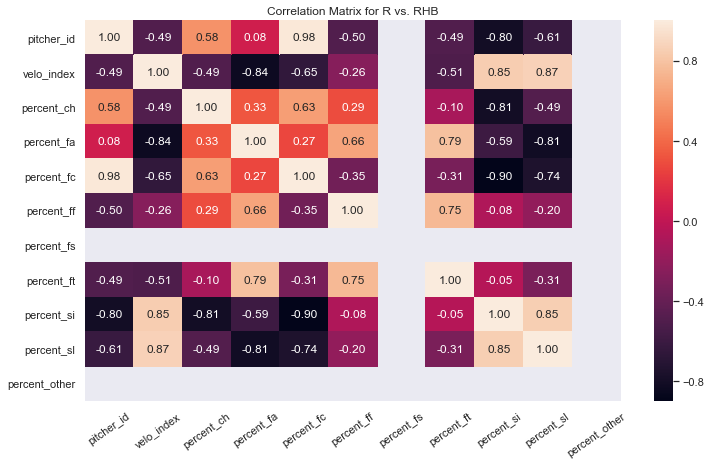

In [9]:
p_throws = "R"
type_of_batters = "RHB"
sns.set(rc={'figure.figsize': (12, 7)})
fig = sns.heatmap(df.corr(), annot=True, fmt=".2f")
for tick in fig.get_xticklabels():
    tick.set_rotation(35)
plt.title("Correlation Matrix for {} vs. {}".format(p_throws, type_of_batters))
plt.show();

There are some interesting preliminary results in this matrix. The strongest correlation (for positive or negative) is the negative correlation between Sinkers (SI) and Fastballs (FA). This makes intuitive sense, as pitcher who throws sinkers would throw complimentary offspeed pitches, not more hard pitches like a fastball or four-seamer. Another correlation (.33) is the relationship between velo_index and Four-Seam Fastballs (FF). Four-Seam Fastballs are considers the fastest pitch, and so it's not suprising that pitchers that throw a lot of them have higher velo_indexes.


## Analyzing Variance 

I'm using R pitchers against RHB as an example. Based on the analysis below, .01 could be a good minimum variance threshold.

In [10]:
df = pandas.read_sql_query("select * from normalized where p_throws='{}' and type_of_batters='{}';".format(p_throws, type_of_batters), conn)
df = df.drop(["pitcher_id", "p_throws", "type_of_batters", "index"], axis=1)

print("\nLowest variance before filtering for {} vs. {}:".format(p_throws, type_of_batters))
print(df.var().sort_values().to_string())
threshold = .01
threshold_obj = VarianceThreshold(threshold=threshold).fit(df)
filtered_out_columns = [column for column in df.columns if column not in df.columns[threshold_obj.get_support()]]

print("\nFiltering out columns for variance lower than {}: {}".format(threshold, filtered_out_columns))
df_filtered = df[df.columns[threshold_obj.get_support(indices=True)]]
print("\nLowest variance after filtering: ")
print(df_filtered.var().sort_values().to_string())


Lowest variance before filtering for R vs. RHB:
percent_other    0.003873
percent_ft       0.003935
percent_ff       0.004590
percent_fs       0.007829
velo_index       0.015928
percent_ch       0.018145
percent_fc       0.023727
percent_cu       0.037046
percent_si       0.046484
percent_fa       0.047688
percent_sl       0.054586

Filtering out columns for variance lower than 0.01: ['percent_ff', 'percent_fs', 'percent_ft', 'percent_other']

Lowest variance after filtering: 
velo_index    0.015928
percent_ch    0.018145
percent_fc    0.023727
percent_cu    0.037046
percent_si    0.046484
percent_fa    0.047688
percent_sl    0.054586


## Cluster Analysis

### Finding K using the Elbow Method

I calculated the sum of squared distances for each combination of k between 1 and 15. The KneeLocator library, helps us detect the point where the squared distances slows down.


Sum of Squared Distances for kn.knee=4: 81.6347919383488


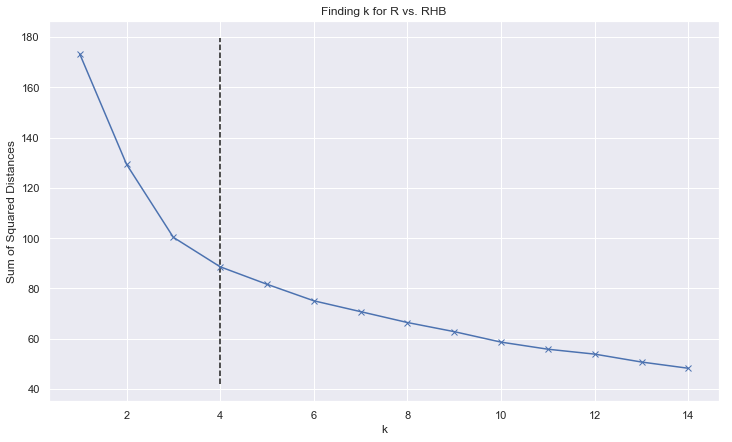

In [11]:
sum_of_squared_distances = []
k_range = range(1, 15)
for k in k_range:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(k_range, sum_of_squared_distances, 'bx-')
plt.xlabel("k")
plt.ylabel("Sum of Squared Distances")
plt.title("Finding k for {} vs. {}".format(p_throws, type_of_batters))

y = sum_of_squared_distances
x = range(1, len(y) + 1)
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print("\nSum of Squared Distances for kn.knee={}: {}".format(kn.knee, sum_of_squared_distances[kn.knee]))
plt.show();

What happens if we use variance threshold and drop the variables with variances below .01?


Sum of Squared Distances for kn.knee=4: 68.65838219112672


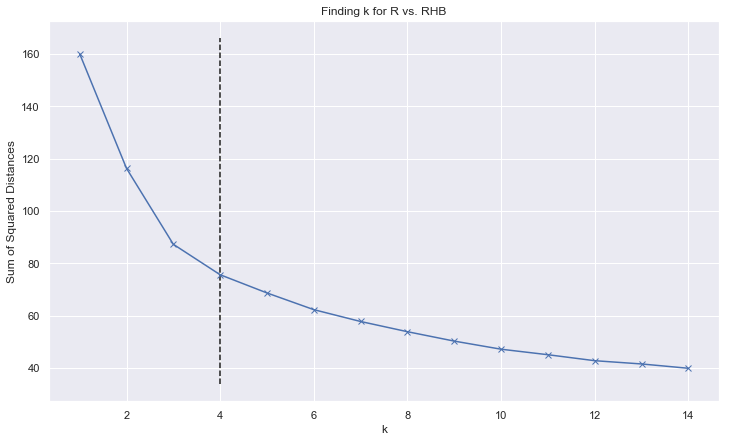

In [12]:
sum_of_squared_distances = []
k_range = range(1, 15)
for k in k_range:
    km = KMeans(n_clusters=k)
    km = km.fit(df_filtered)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(k_range, sum_of_squared_distances, 'bx-')
plt.xlabel("k")
plt.ylabel("Sum of Squared Distances")
plt.title("Finding k for {} vs. {}".format(p_throws, type_of_batters))

y = sum_of_squared_distances
x = range(1, len(y) + 1)
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print("\nSum of Squared Distances for kn.knee={}: {}".format(kn.knee, sum_of_squared_distances[kn.knee]))
plt.show();

The sum of squared distances went from 81.6 to 68.6, both for k = 4 clusters.